In [49]:
import json
import requests
import pickle
import crashsimilarity.downloader as cd
from crashsimilarity.utils import StackTraceProcessor
import crashsimilarity.tmp as tmp
from gensim.models import doc2vec
import numpy as np
import matplotlib.pyplot as plt
import logging

In [9]:
r = requests.get('https://crash-stats.mozilla.com/api/SuperSearch/?product=Firefox&_facets=signature&_facets_size=20')

In [10]:
facets = r.json()['facets']
# facets

In [11]:
sig1 = facets['signature'][6]
sig1

{'count': 9554,
 'term': 'AsyncShutdownTimeout | profile-before-change | MediaShutdownManager: shutdown'}

In [12]:
sig2 = facets['signature'][10]
sig2

{'count': 8163, 'term': 'js::GCMarker::eagerlyMarkChildren'}

In [13]:
traces = cd.SocorroDownloader().download_stack_traces_for_signature(sig1['term'], 150)
traces1 = list(traces)
traces = cd.SocorroDownloader().download_stack_traces_for_signature(sig2['term'], 150)
traces2 = list(traces)

In [14]:
traces1 = [StackTraceProcessor.preprocess(i) for i in traces1]
traces2 = [StackTraceProcessor.preprocess(i) for i in traces2]

In [2]:
vocab = pickle.load(open('data/compressed_vocab.pickle', 'rb'))
len(vocab)

222895

In [37]:
def compress(words):
    new = 0
    rv = []
    for w in words:
        if w not in vocab:
            new += 1
            rv.append(w)
        else:
            rv.append(str(vocab[w]))
    return new, rv

In [38]:
compressed_traces1 = []
new = []
for t in traces1:
    n, c = compress(t)
    new.append(n)
    compressed_traces1.append(c)
sum(new)

226

In [39]:
compressed_traces2 = []
new = []
for t in traces2:
    n, c = compress(t)
    new.append(n)
    compressed_traces2.append(c)
sum(new)

0

In [40]:
sample = []
for i, c in enumerate(compressed_traces1):
    sample.append(doc2vec.TaggedDocument(c, [i]))
for i, c in enumerate(compressed_traces2):
    sample.append(doc2vec.TaggedDocument(c, [i+len(compressed_traces1)]))

In [3]:
corpus = list(tmp.corpus_generator('data/new_clean_compressed.json'))

In [4]:
model = doc2vec.Doc2Vec(size=200, window=15, iter=10, workers=8, min_count=1)
model.build_vocab(corpus)
len(model.wv.vocab)

INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #10000, processed 266289 words (2448986/s), 20908 word types, 10000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #20000, processed 534166 words (3069406/s), 29722 word types, 20000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #30000, processed 806104 words (3489343/s), 36392 word types, 30000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #40000, processed 1077950 words (3299025/s), 41995 word types, 40000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #50000, processed 1351572 words (3392459/s), 46766 word types, 50000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #60000, processed 1624010 words (3307255/s), 50914 word types, 60000 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #70000, processed 1894651 words (3370555/s), 54864 word type

222894

In [5]:
model.train(corpus)

INFO:gensim.models.word2vec:training model with 8 workers on 222894 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=5 window=15
INFO:gensim.models.word2vec:expecting 1415691 sentences, matching count from corpus used for vocabulary survey
INFO:gensim.models.word2vec:PROGRESS: at 0.07% examples, 206574 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:PROGRESS: at 0.17% examples, 256662 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:PROGRESS: at 0.27% examples, 275067 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:PROGRESS: at 0.38% examples, 283887 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:PROGRESS: at 0.48% examples, 288405 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:PROGRESS: at 0.59% examples, 291817 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:PROGRESS: at 0.69% examples, 294078 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:PROGRESS: at 0.79% examples,

338623974

In [6]:
model.save('data/model/dm_d200_all.model')

INFO:gensim.utils:saving Doc2Vec object under data/model/dm_d200_all.model, separately None
INFO:gensim.utils:storing np array 'syn0' to data/model/dm_d200_all.model.wv.syn0.npy
INFO:gensim.utils:not storing attribute syn0norm
INFO:gensim.utils:storing np array 'doctag_syn0' to data/model/dm_d200_all.model.docvecs.doctag_syn0.npy
INFO:gensim.utils:storing np array 'syn1neg' to data/model/dm_d200_all.model.syn1neg.npy
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved data/model/dm_d200_all.model


In [13]:
model = doc2vec.Doc2Vec.load('data/model/dm_d200_all.model')

INFO:gensim.utils:loading Doc2Vec object from data/model/dm_d200_all.model
INFO:gensim.utils:loading wv recursively from data/model/dm_d200_all.model.wv.* with mmap=None
INFO:gensim.utils:loading syn0 from data/model/dm_d200_all.model.wv.syn0.npy with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:loading docvecs recursively from data/model/dm_d200_all.model.docvecs.* with mmap=None
INFO:gensim.utils:loading doctag_syn0 from data/model/dm_d200_all.model.docvecs.doctag_syn0.npy with mmap=None
INFO:gensim.utils:loading syn1neg from data/model/dm_d200_all.model.syn1neg.npy with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded data/model/dm_d200_all.model


In [7]:
type(model)

gensim.models.doc2vec.Doc2Vec

In [30]:
words = set()
for c in sample:
    for w in c.words:
        words.add(w)
words = list(words)
c = sum([1 if w in vocab.values() else 0 for w in words])
c

286

In [34]:
type(words[0])

int

In [41]:
sample[0]

TaggedDocument(words=['547'], tags=[0])

In [35]:
m = sum([1 if str(w) in model else 0 for w in words])
m

286

In [30]:
len(vocab)

222895

In [46]:
sample[228]

TaggedDocument(words=['1019', '281', '427', '428', '429', '197', '198', '199', '204', '200', '201', '202', '430', '431', '214', '215', '216', '217', '218', '219', '15', '68', '70', '23', '24', '72', '73', '220', '221', '125', '126', '156', '28', '29', '222'], tags=[228])

In [47]:
ans = tmp.rwmd_distances(model, sample, 228)

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors
INFO:root:words in model: 35
INFO:root:First part done in 0.019847631454467773 s.


In [50]:
logging.root.setLevel(logging.CRITICAL)
dist = np.zeros((len(sample), len(sample)), dtype=np.double)
for i in range(len(sample)):
    if i % 50 == 0:
        print(i)
    dist[i] = np.array(tmp.rwmd_distances(model, sample, i))[:,1]
logging.root.setLevel(logging.INFO)

0
50
100
150
200
250


In [51]:
dist

array([[  0.00000000e+00,   1.93762892e+00,   3.71827006e+01, ...,
          3.26619667e+01,   3.79528596e+01,   3.46636138e+01],
       [  1.93762892e+00,   0.00000000e+00,   1.61016598e+01, ...,
          2.68110479e+01,   3.12727913e+01,   2.89486871e+01],
       [  3.71827011e+01,   1.61016598e+01,  -1.37090683e-06, ...,
          3.04987394e+01,   3.22008166e+01,   3.18486030e+01],
       ..., 
       [  3.26619666e+01,   2.68110478e+01,   3.04987394e+01, ...,
         -1.78813934e-07,   9.19115722e+00,   7.54128063e+00],
       [  3.79528593e+01,   3.12727913e+01,   3.22008166e+01, ...,
          9.19115722e+00,   3.57627869e-07,   3.02354425e+00],
       [  3.46636137e+01,   2.89486868e+01,   3.18486030e+01, ...,
          7.54128104e+00,   3.02354461e+00,   1.19209290e-06]])

In [52]:
from sklearn.manifold import MDS
clf = MDS()
X_mds = clf.fit_transform(dist)
X_mds.shape

/home/kirill/anaconda3/lib/python3.6/site-packages/sklearn/manifold/mds.py:396: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(300, 2)

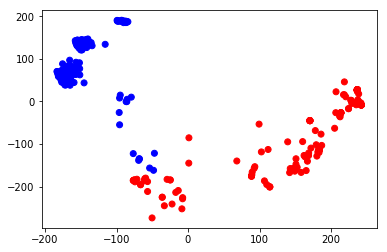

In [53]:
color = 'r' * len(compressed_traces1) + 'b' * len(compressed_traces1)
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=color)
plt.show()